Import libraries

In [2]:
import os
import shutil
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model,Sequential,save_model,load_model
from tensorflow.config import list_physical_devices
from tensorflow.config.experimental import set_memory_growth

import warnings
warnings.filterwarnings("ignore")

2025-05-12 10:39:55.578814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747046395.766828      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747046395.820356      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [1]:
root_dir = r"/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset"
out_dir = r"/kaggle/working"

In [4]:
count = 0
f = 0
for folder in os.listdir(root_dir):    
    folder_paths = os.path.join(root_dir,folder)
    for image in folder_paths:
        count += 1
print(count)

6466


In [5]:
device = list_physical_devices("GPU")
print(device)

if device:
    try:
        tf.config.experimental.set_memory_growth(device[0], True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
for folder in os.listdir(root_dir):    
    folder_paths = os.path.join(out_dir,"data",str(folder))
    os.makedirs(folder_paths,exist_ok = True)

data validation

In [4]:
from PIL import Image

def validate_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Raises an error for corrupt images
        return True
    except Exception as e:
        print(f"Invalid image for {image_path}: {e}")
        return False

In [5]:
data = r"/kaggle/working/data"

for names in os.listdir(data):
    filepaths = os.path.join(root_dir,names)
    for files in os.listdir(filepaths):
            val = validate_image(os.path.join(filepaths,files))
            if val:
                image = Image.open(os.path.join(filepaths,files))
                image.save(os.path.join(data,names,files))

Invalid image for /kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Sapota/VID_20190921_120806.mp4: cannot identify image file '/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Sapota/VID_20190921_120806.mp4'
Invalid image for /kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Spinach1/VID_20190917_104022.mp4: cannot identify image file '/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Spinach1/VID_20190917_104022.mp4'
Invalid image for /kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Spinach1/VID_20190917_103758.mp4: cannot identify image file '/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Spinach1/VID_20190917_103758.mp4'
Invalid image for /kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf dataset/Spinach1/VID_20190917_103955.mp4: cannot identify image file '/kaggle/input/indian-medicinal-leaf-image-dataset/Medicinal Leaf datase

data preparation

In [9]:
batch_size = 32
image_width = 224
image_height = 224

In [10]:
dataset = image_dataset_from_directory(
             data,
             labels = 'inferred',
             label_mode = 'int',
             color_mode = 'rgb',
             class_names = None,
             batch_size = batch_size,
             image_size=(image_height,image_width),
             shuffle=True,
             seed=123,
             )

Found 6900 files belonging to 80 classes.


I0000 00:00:1746534835.748924      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [11]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape, label_batch.shape)

(32, 224, 224, 3) (32,)


split the data

In [12]:
# Train data

train_size = 0.8 
train_data = dataset.take(int(len(dataset)*train_size))
print(len(train_data))

172


In [13]:
test_data = dataset.skip(int(len(dataset)*train_size))

val_size = 0.1

valid_data = test_data.take(int(len(dataset)*val_size))

test_data = test_data.skip(int(len(dataset)*val_size))

print(len(valid_data),len(test_data))

21 23


Load data into memory

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size = AUTOTUNE)

valid_data = valid_data.cache().prefetch(buffer_size = AUTOTUNE)

test_data = test_data.cache().prefetch(buffer_size = AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(image_height,image_width),
  tf.keras.layers.Rescaling(1./255),
])


Model creation

In [ ]:
import tensorflow as tf

def create_model():
    # 1. Charger le modèle pré-entraîné
    base_model = tf.keras.applications.InceptionResNetV2(
        include_top=False,  # On enlève la dernière couche de classification d'origine
        weights='imagenet', # On garde les poids pré-entraînés
        input_shape=(224, 224, 3)
    )

    # 2. Dire qu’on veut modifier les couches du haut (fine-tuning)
    base_model.trainable = True  # On veut modifier certaines couches

    # 3. On bloque (gèle) les premières couches pour ne pas les toucher
    for layer in base_model.layers[:600]:  # Gèle les 600 premières couches
        layer.trainable = False

    # 4. Construire ton nouveau modèle avec la propre "tête"
    model = tf.keras.Sequential([
        tf.keras.layers.Input((224,224,3)),
        resize_and_rescale,
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),  # remplace Flatten (meilleur ici)
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(80, activation='softmax')  
    ])

    return model


In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

boundaries = [20, 35]
values = [0.0001, 0.0005, 0.001]

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)

checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_weights.weights.h5',
    save_best_only=True,
    monitor='val_accuracy',
    save_weights_only=True,
    verbose=1
)


# EarlyStopping callback to stop training if validation accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    min_delta=0.05,  # Minimum required change in the monitored metric
    patience=50,  # Number of epochs with no improvement to wait before stopping
    baseline = 0.5,
    restore_best_weights=True  # Restore the weights of the best model before stopping
)

In [33]:
stratergy = tf.distribute.experimental.CentralStorageStrategy()


with stratergy.scope():
    
    model = create_model(freeze = False)
  
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

# Train the model on the replicated dataset
    history = model.fit(train_data,
                        epochs=30, 
                        validation_data=valid_data,
                        callbacks=[checkpoint, early_stopping])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 5, 5, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       9,830,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 80)                  │          10,320 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,210,608 (244.94 MB)

 Trainable params: 64,150,064 (244.71 MB)

 Non-trainable params: 60,544 (236.50 KB)

Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.0595 - loss: 4.2730
Epoch 1: val_accuracy improved from -inf to 0.15774, saving model to /kaggle/working/best_weights.weights.h5
172/172 ━━━━━━━━━━━━━━━━━━━━ 191s 578ms/step - accuracy: 0.0597 - loss: 4.2715 - val_accuracy: 0.1577 - val_loss: 3.6170
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.2164 - loss: 3.2692
Epoch 2: val_accuracy did not improve from 0.15774
172/172 ━━━━━━━━━━━━━━━━━━━━ 88s 511ms/step - accuracy: 0.2164 - loss: 3.2688 - val_accuracy: 0.0134 - val_loss: 5.7898
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.2449 - loss: 3.0393
Epoch 3: val_accuracy improved from 0.15774 to 0.16220, saving model to /kaggle/working/best_weights.weights.h5
172/172 ━━━━━━━━━━━━━━━━━━━━ 92s 535ms/step - accuracy: 0.2450 - loss: 3.0388 - val_accuracy: 0.1622 - val_loss: 24.5821
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.3608 - loss: 2.4076
Epoch 4: val_a

In [34]:
model.save("/kaggle/working/model_final.keras")

In [35]:
model.evaluate(test_data)

23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 517ms/step - accuracy: 0.8105 - loss: 0.7304


[0.7756569385528564, 0.7941988706588745]

In [37]:
train_accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

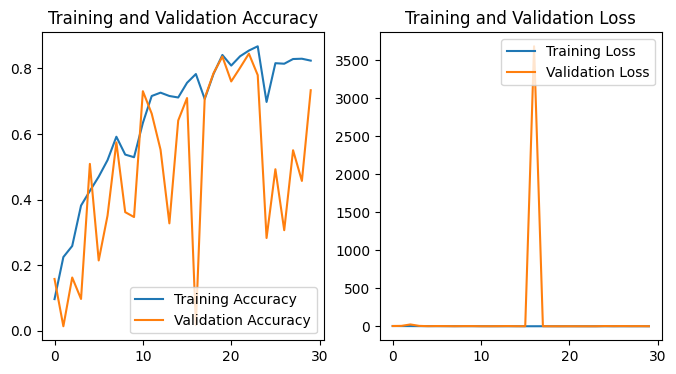

In [39]:
epochs = 30
plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.plot(range(epochs),train_accuracy, label = 'Training Accuracy')
plt.plot(range(epochs),val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(epochs),train_loss, label = 'Training Loss')
plt.plot(range(epochs),val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [43]:
classnames = dataset.class_names

In [44]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)       # Creating a batch with the image
    
    predictions = model.predict(img_array,verbose = 0)
    predicted_class = classnames[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

In [45]:
print(len(train_data),len(valid_data),len(test_data))
for images,labels in test_data.take(1):
    print(images.numpy().shape)

172 21 23
(32, 224, 224, 3)


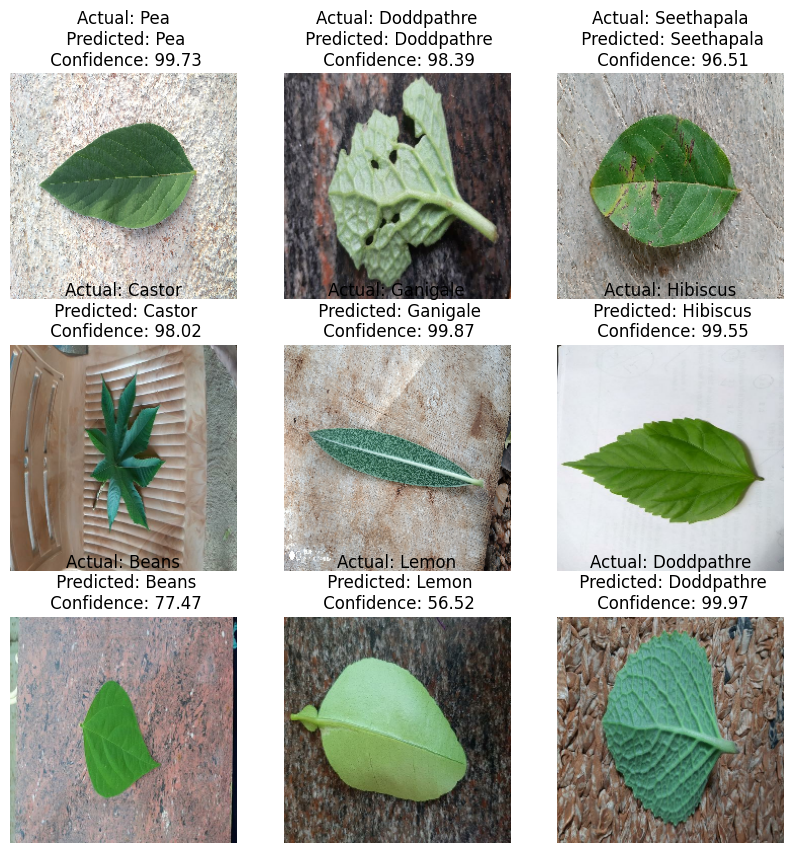

In [47]:
plt.figure(figsize = (10,10))
for images,labels in valid_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.axis("off")
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted, confidence = predict(model, images.numpy())
        plt.title(f"Actual: {classnames[labels[i]]}\n Predicted: {predicted}\n Confidence: {confidence}")
#     predicted_class = classnames[np.argmax(predicted[0])]
#     print(predicted_class, classnames[labels[i]])

Download the model for flutter

In [48]:
from tensorflow import keras
model = keras.models.load_model("/kaggle/working/model_final.keras")

import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: for size/performance
tflite_model = converter.convert()
with open("/kaggle/working/model_final.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmphzm6l67x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 80), dtype=tf.float32, name=None)
Captures:
  136135305930768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135305933264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135305932496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135305931536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135305923280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135305922512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135305927696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135305923088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135305935952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135305930000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136135305924

W0000 00:00:1746539851.560145      31 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1746539851.560204      31 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1746539852.106393      31 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


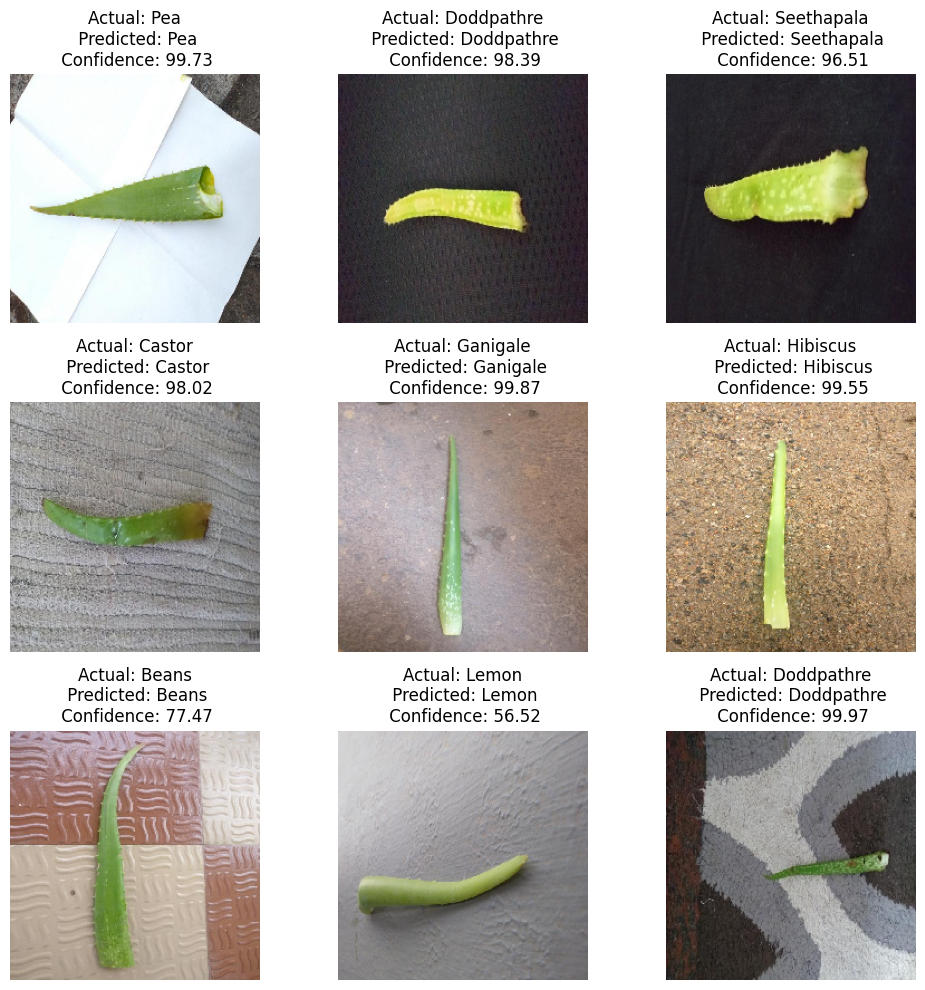

In [53]:
folder_path = "/kaggle/working/data/Aloevera"

# Get list of image file paths
image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths[:9]):
    # Load and preprocess the image
    image = tf.keras.utils.load_img(image_path, target_size=(224, 224))  # Adjust size if needed
    image_array = tf.keras.utils.img_to_array(image)
    image_array = tf.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize if your model expects that

    # Predict
    predicted, confidence = predict(model, image_array)

    # Plot
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Actual: {classnames[labels[i]]}\n Predicted: {predicted}\n Confidence: {confidence}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
!pip install gdown

import gdown

url = 'https://drive.google.com/uc?id=1w8x5qGrUldFNIalbZ0I5hSYxxijdy-5b'

output = 'model_final'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1w8x5qGrUldFNIalbZ0I5hSYxxijdy-5b
To: /kaggle/working/model_final
100%|██████████| 65.5M/65.5M [00:01<00:00, 44.2MB/s]


'model_final'

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

In [47]:
test_folder = "/kaggle/working/data/Ginger"
image_paths = [os.path.join(test_folder, fname) for fname in os.listdir(test_folder) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]


In [48]:
classnames = ["Ginger"]  # Adjust this list if more classes exist
true_label_index = 0
#lemon, aloevera , beans, Mint , Onion , Pumpkin , Rose, Tomato, Pepper , Jasmine , Ginger 


In [39]:
interpreter = tf.lite.Interpreter(model_path="/kaggle/working/model_final")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def predict_tflite(image):
    input_shape = input_details[0]['shape'][1:3]
    image = image.resize(input_shape)
    image_np = np.expand_dims(np.array(image, dtype=np.float32) / 255.0, axis=0)

    interpreter.set_tensor(input_details[0]['index'], image_np)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])[0]
    predicted_index = np.argmax(output)
    confidence = np.max(output)
    return predicted_index, confidence


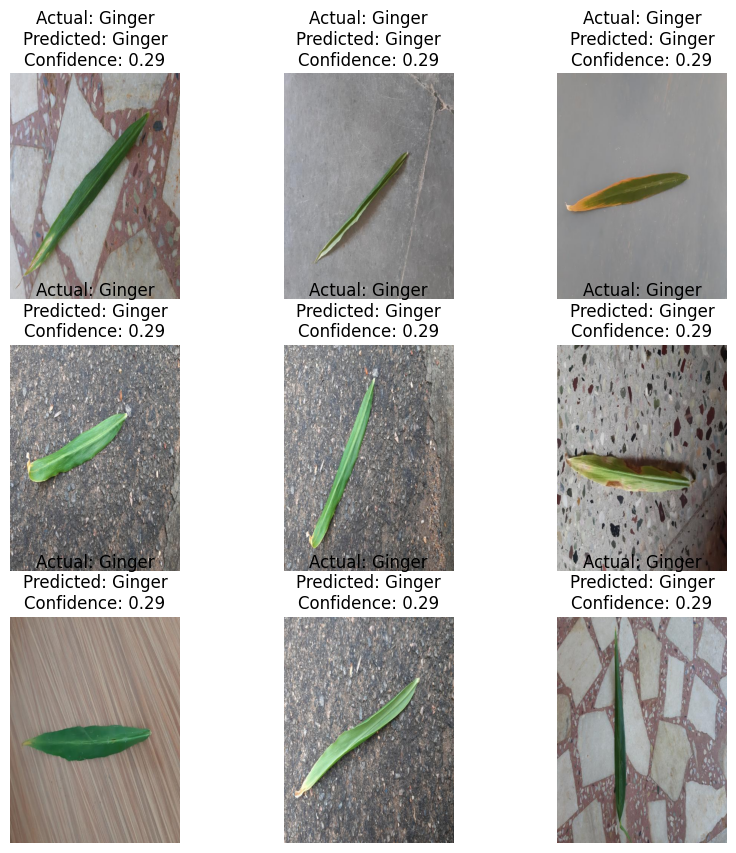

In [49]:
plt.figure(figsize=(10,10))

for i, image_path in enumerate(image_paths[:9]):  # Show up to 9 samples
    img = Image.open(image_path).convert("RGB")
    predicted_idx, confidence = predict_tflite(img)
    
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    
    plt.title(f"Actual: {classnames[true_label_index]}\nPredicted: {classnames[predicted_idx]}\nConfidence: {confidence:.2f}")
